# Опредение возраста по фотографии

## Описание проекта

В моем распоряжении набор фотографий с указанием возвраста. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

### Содержание:

#### 1) <a href='#First look'> Изучение данных</a>
#### 2) <a href='#Model training'> Обучение модели</a>
#### 3) <a href='#Conclusion'> Вывод</a>

<a id='First look'></a>
## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory='/datasets/faces/final_files/',
        x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=32, class_mode='raw', seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
print(labels.shape)

(7591, 2)


In [6]:
features, target = next(train_gen_flow)

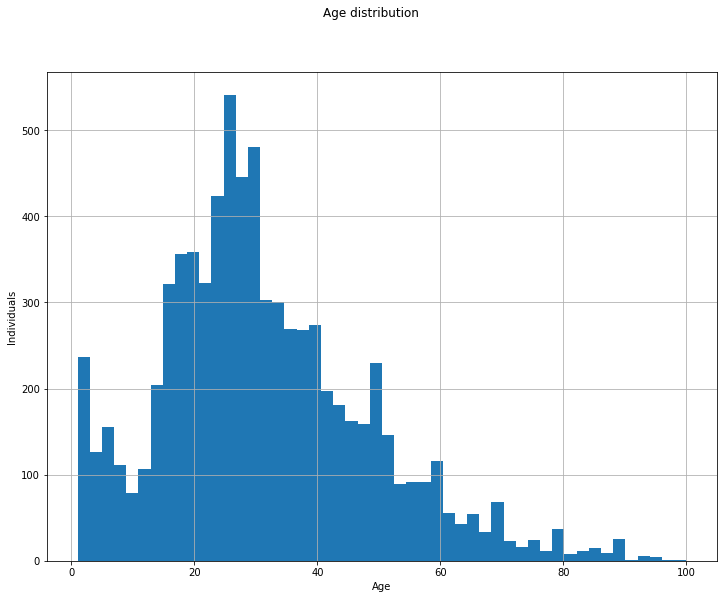

In [7]:
plot = labels.real_age.hist(bins=50, figsize=(12,9) );
plt.suptitle('Age distribution');
plot.set_xlabel("Age");
plot.set_ylabel("Individuals");

Больше всего в датасете фотграфий с людьми возврастом от 16 до 36 лет. Меньше всего фото с людьми от 60 до 100 лет.

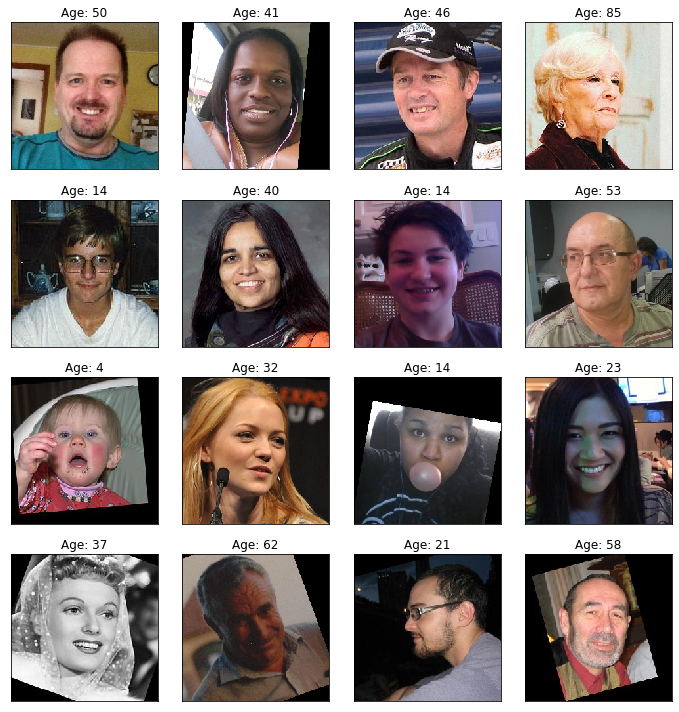

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

В обучающей выборке содержатся как цветные, так и черно-белые фотографии. Некоторые фотографии имеют рамки, также некоторые рамки поввернуты и имеют различный размер.

<a id='Model training'></a>
## Обучение модели

Код в этом разделе запускался в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=16, class_mode='raw',
        subset='training', seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=16, class_mode='raw',
        subset='validation', seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

    return model

```

Вывод в процессе обучения модели:

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 51s - loss: 205.3043 - mae: 10.8542 - val_loss: 282.4117 - val_mae: 13.0726
Epoch 2/20
356/356 - 41s - loss: 135.6535 - mae: 8.9446 - val_loss: 261.2379 - val_mae: 12.2952
Epoch 3/20
356/356 - 42s - loss: 108.0608 - mae: 7.9280 - val_loss: 189.0495 - val_mae: 10.4476
Epoch 4/20
356/356 - 41s - loss: 94.1413 - mae: 7.3961 - val_loss: 126.7644 - val_mae: 8.5919
Epoch 5/20
356/356 - 41s - loss: 76.8990 - mae: 6.6829 - val_loss: 167.8610 - val_mae: 10.0353
Epoch 6/20
356/356 - 42s - loss: 66.3826 - mae: 6.2430 - val_loss: 114.5904 - val_mae: 8.0066
Epoch 7/20
356/356 - 42s - loss: 53.1261 - mae: 5.6359 - val_loss: 98.4335 - val_mae: 7.6400
Epoch 8/20
356/356 - 42s - loss: 49.1304 - mae: 5.4087 - val_loss: 106.0904 - val_mae: 8.0104
Epoch 9/20
356/356 - 41s - loss: 39.4709 - mae: 4.8785 - val_loss: 87.2663 - val_mae: 6.9728
Epoch 10/20
356/356 - 41s - loss: 31.0617 - mae: 4.3249 - val_loss: 108.7126 - val_mae: 7.6944
Epoch 11/20
356/356 - 42s - loss: 31.5262 - mae: 4.2953 - val_loss: 99.1225 - val_mae: 7.3340
Epoch 12/20
356/356 - 41s - loss: 31.5505 - mae: 4.3095 - val_loss: 88.0052 - val_mae: 7.1019
Epoch 13/20
356/356 - 42s - loss: 24.5739 - mae: 3.8380 - val_loss: 84.8989 - val_mae: 6.9310
Epoch 14/20
356/356 - 41s - loss: 26.1692 - mae: 3.8842 - val_loss: 87.9638 - val_mae: 7.1529
Epoch 15/20
356/356 - 42s - loss: 23.3320 - mae: 3.7272 - val_loss: 85.0499 - val_mae: 6.8930
Epoch 16/20
356/356 - 42s - loss: 20.5101 - mae: 3.4765 - val_loss: 81.5310 - val_mae: 6.8132
Epoch 17/20
356/356 - 41s - loss: 19.7295 - mae: 3.4346 - val_loss: 88.5583 - val_mae: 6.9604
Epoch 18/20
356/356 - 41s - loss: 18.7786 - mae: 3.2993 - val_loss: 77.6942 - val_mae: 6.7196
Epoch 19/20
356/356 - 41s - loss: 16.6634 - mae: 3.1212 - val_loss: 85.5162 - val_mae: 6.8821
Epoch 20/20
356/356 - 42s - loss: 15.8781 - mae: 3.0489 - val_loss: 84.8159 - val_mae: 6.9295
119/119 - 10s - loss: 84.8159 - mae: 6.9295
Test MAE: 6.9295


```

<a id='Conclusion'></a>
## Вывод

Для обучения модели была использована сеть ResNet50, предобученная на датасете ImageNet. Получилось обучить модель, которая определяет возвраст по фотографии со средней ошибкой в 7 лет. На тренировочной выборке исользовалась аугментация.